# Hotel Review Analysis

In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.svm import LinearSVC
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from pprint import pprint
import time
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.matutils import corpus2csc
import pyLDAvis
import pyLDAvis.gensim_models
from nltk.tokenize import word_tokenize
from textblob import TextBlob

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 載入資料

In [5]:
review = pd.read_csv("./raw_data/reviews.csv")
offering = pd.read_csv("./raw_data/offerings.csv")
offering = offering[offering['hotel_class'].notna()]
data = review.merge(offering, left_on="offering_id", right_on="id", suffixes=("_review", "_hotel"))
data.head(2)

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id_review,via_mobile,hotel_class,region_id,url,phone,details,address,type,id_hotel,name
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,2012-12-17,147643103,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon
1,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...","{'username': 'Maureen V', 'num_reviews': 2, 'n...",December 2012,93338,0,2012-12-17,147639004,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon


# 清洗資料
- 詞幹正規化 & 停用字 & 小寫 & 單一字

In [8]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z ]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

data['tokens'] = data['text'].astype(str).apply(preprocess)

## LDA模型
- 將hotel分類為 1-2 / 2-3 / 3-4 / 4-5 星，新增欄位hotel_class_group
- 對這些欄位對應的評論做LDA

- 以 1-2 星等的評論為例 print_topics()的output如下:
Topic 1: 0.058*"e" + 0.022*"di" + 0.017*"per" + 0.016*"che" + 0.015*"non" + 0.014*"da" + 0.011*"il" + 0.011*"la" + 0.010*"una" + 0.009*"un"
Topic 2: 0.009*"night" + 0.009*"stay" + 0.008*"u" + 0.008*"door" + 0.008*"one" + 0.007*"would" + 0.006*"place" + 0.006*"even" + 0.006*"dirty" + 0.006*"like"
Topic 3: 0.052*"de" + 0.040*"le" + 0.028*"la" + 0.026*"et" + 0.018*"pa" + 0.017*"un" + 0.012*"est" + 0.012*"en" + 0.012*"pour" + 0.011*"dans"
Topic 4: 0.012*"clean" + 0.011*"place" + 0.011*"stay" + 0.010*"night" + 0.008*"good" + 0.008*"staff" + 0.008*"location" + 0.008*"time" + 0.008*"would" + 0.008*"bed"
Topic 5: 0.054*"de" + 0.049*"la" + 0.038*"que" + 0.031*"en" + 0.029*"el" + 0.020*"e" + 0.013*"por" + 0.013*"lo" + 0.013*"un" + 0.011*"para"
- 意義: Topic 1 跟 'e', 'di', 'per'... 有關；Topic 2 跟 'night', 'stay', 'door', 'dirty' 有關
- 為什麼會有'e', 'di', 'per':
'e'、'di'、'per' -> 義大利文（和、的、為了）
'de'、'la'、'le' -> 法文、西班牙文（的、那個）
'und'、'die', 'der' -> 德文（和、她、他）
代表資料是多語系的，需要再過濾

In [9]:
# 分區間定義函式
def get_hotel_class_group(hotel_class):
    if 1.0 <= hotel_class < 2.0:
        return "1~2"
    elif 2.0 <= hotel_class < 3.0:
        return "2~3"
    elif 3.0 <= hotel_class < 4.0:
        return "3~4"
    elif 4.0 <= hotel_class <= 5.0:
        return "4~5"
    else:
        return "other"

In [13]:
data['hotel_class_group'] = data['hotel_class'].apply(get_hotel_class_group)

# bigram
docs = [[word for word in doc if word not in stop_words and len(word) > 2] for doc in data['tokens']]
len(docs)
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # 將Token (bigram) 加入到docs裡面
            docs[idx].append(token)
                

# 做 LDA 主題模型分析（每組跑一次）
t0 = time.time()
groups = ["1~2", "2~3", "3~4", "4~5"]
lda_results = {}

for group in groups:
    group_data = data[data['hotel_class_group'] == group]
    texts = [docs[idx] for idx in group_data.index]
    
    # 建立 docs 的 dictionary物件
    dictionary = Dictionary(texts)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in texts]
    print(dictionary)
                
    # 跳過太少樣本的主題
    if len(texts) < 10:
        print(f"Group {group} has too few samples, skipping...")
        continue
    
    # 尋找最佳主題數 num_topics（根據 C_v coherence）
    coherence_scores = []
    # 測試 2~8
    # 避免極端值（如 topic=1）、太多會也過於破碎
    # for k in range(2, 8):
    #     model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=k, random_state=42, passes=10)
    #     cm = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    #     coherence_scores.append(cm.get_coherence())

    # best_k = range(2, 11)[coherence_scores.index(max(coherence_scores))]
    # print(f"Group {group} 最佳主題數為 {best_k}")
    
    
    
    # 訓練 LDA 模型    
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=5,
                         random_state=42,
                         passes=5,
                         alpha='auto',
                         per_word_topics=True)
    
    lda_results[group] = {
        "model": lda_model,
        "dictionary": dictionary,
        "corpus": corpus
    }

    # 顯示主題
    print(f"\n=== LDA Topics for Hotel Class {group} ===")
    topics = lda_model.print_topics(num_words=10)
    for topic_num, topic_words in topics:
        print(f"Topic {topic_num + 1}: {topic_words}")
        
print(f"花費時間: {time.time() - t0} sec")

Dictionary<10174 unique tokens: ['air', 'anderson', 'apple', 'awhile', 'balcony']...>

=== LDA Topics for Hotel Class 1~2 ===
Topic 1: 0.023*"und" + 0.020*"que" + 0.020*"die" + 0.014*"ist" + 0.014*"der" + 0.011*"war" + 0.010*"zimmer" + 0.010*"nicht" + 0.010*"man" + 0.008*"ein"
Topic 2: 0.010*"night" + 0.009*"stay" + 0.009*"place" + 0.008*"one" + 0.008*"would" + 0.006*"bed" + 0.006*"get" + 0.006*"door" + 0.006*"didnt" + 0.006*"clean"
Topic 3: 0.016*"est" + 0.015*"pour" + 0.014*"dans" + 0.014*"nous" + 0.012*"chambre" + 0.012*"mais" + 0.010*"une" + 0.010*"que" + 0.009*"det" + 0.009*"trs"
Topic 4: 0.017*"che" + 0.016*"per" + 0.016*"non" + 0.010*"una" + 0.009*"que" + 0.008*"een" + 0.007*"con" + 0.007*"het" + 0.007*"com" + 0.007*"quarto"
Topic 5: 0.014*"stay" + 0.013*"new" + 0.012*"time" + 0.010*"york" + 0.010*"new_york" + 0.010*"would" + 0.009*"location" + 0.007*"inn" + 0.007*"day" + 0.007*"carter"
Dictionary<61514 unique tokens: ['best', 'beyond', 'decent', 'desk', 'eager']...>

=== LDA To

### 視覺化Perplexity 和 PMI 評估主題模型表現
+ **Pointwise Mutual Information (PMI)** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\USER\AppData\Local\Temp\ipykernel_29344\1253052475.py:31: UserWarning: Glyph 20027 (\N{CJK UNIFIED IDEOGRAPH-4E3B}) missing from current font.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_29344\1253052475.py

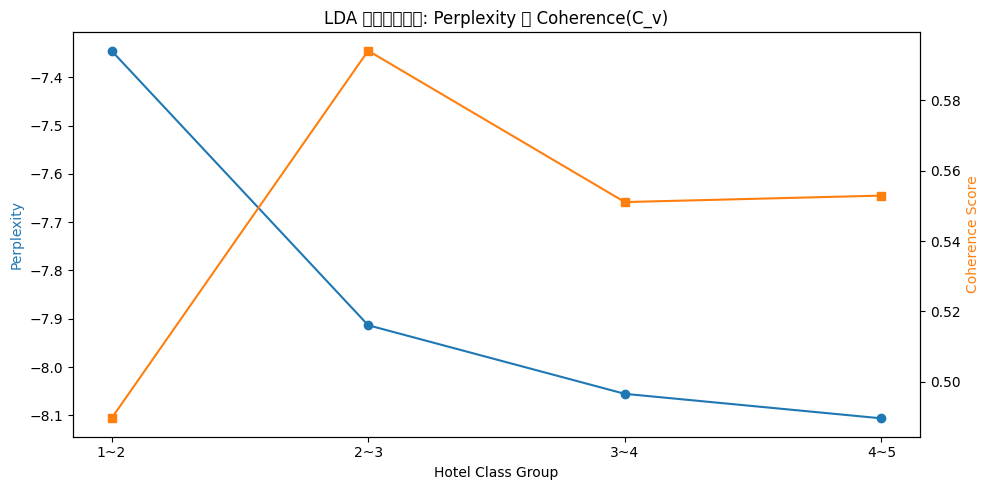

In [14]:
group_metrics = {
    'group': [],
    'perplexity': [],
    'coherence': []
}

for group, content in lda_results.items():
    lda_model = content['model']
    corpus = content['corpus']
    dictionary = content['dictionary']

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()

    group_metrics['group'].append(group)
    group_metrics['perplexity'].append(perplexity)
    group_metrics['coherence'].append(coherence_score)

# Plot
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

ax1.plot(group_metrics['group'], group_metrics['perplexity'], marker='o', color='tab:blue', label='Perplexity')
ax2.plot(group_metrics['group'], group_metrics['coherence'], marker='s', color='tab:orange', label='Coherence')

ax1.set_xlabel('Hotel Class Group')
ax1.set_ylabel('Perplexity', color='tab:blue')
ax2.set_ylabel('Coherence Score', color='tab:orange')
plt.title('LDA 主題模型評估: Perplexity 與 Coherence(C_v)')
plt.tight_layout()
plt.show()

## 3. LDAvis視覺化結果(以1~2星hotel_class為例)

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

- 5個主題數，因此有四個圈圈
- 圓越大代表 document 越大
- 右邊可以看到主題的字分佈
- 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 值高且唯一，因此我們要在這兩者間取平衡
  - λ = 1.0 👉 根據 詞在該主題中出現的機率 排序（也就是根據φ值）
  - λ = 0.0 👉 根據 詞在主題中「相對其他主題」的特異性 排序
- 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

In [35]:
for group in groups:
    lda_model = lda_results[group]['model']
    corpus = lda_results[group]['corpus']
    dictionary = lda_results[group]['dictionary']
    
    # 顯示互動視覺化
    pyLDAvis.enable_notebook()
    graph = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
    graph

## 主題分佈的應用

- 分析每一章節主題的分佈情況

In [36]:
# 取得每章的主題分佈
topics_doc = lda_model.get_document_topics(corpus)

In [37]:
# 將gensim的表示法轉成稀疏矩陣
m_theta = corpus2csc(topics_doc).T.toarray()
theta = pd.DataFrame(m_theta, columns=[f"topic_{i+1}" for i in range(m_theta.shape[1])])
theta

,topic_1,topic_2,topic_3,topic_4,topic_5
0,0.000000,0.662152,0.000000,0.018572,0.318550
1,0.000000,0.616350,0.000000,0.084081,0.299330
2,0.000000,0.266974,0.000000,0.506404,0.226487
3,0.000000,0.014387,0.000000,0.348130,0.637088
4,0.000000,0.151656,0.000000,0.345460,0.502454
...,...,...,...,...,...
364274,0.431765,0.529193,0.000000,0.014272,0.024497
364275,0.953171,0.014194,0.000000,0.010449,0.021969
364276,0.000000,0.010882,0.949071,0.000000,0.030832
364277,0.939383,0.015441,0.000000,0.023784,0.021129


#### 將每個章節的主題機率分布視覺化

- 圖表意義: 1-2星等的評論裡(group = '1~2')，平均來說有約 40% 是在講 Topic 4，只有 4% 是講 Topic 1

C:\Users\USER\AppData\Local\Temp\ipykernel_29344\4196208649.py:14: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from current font.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_29344\4196208649.py:14: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from current font.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_29344\4196208649.py:14: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from current font.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_29344\4196208649.py:14: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from current font.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_29344\4196208649.py:14: UserWarning: Glyph 25972 (\N{CJK UNIFIED IDEOGRAPH-6574}) missing from current font.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_29344\4196208649.py:14: UserWarning: Glyph 39636 (\N{CJK UNIFIED IDEOGRAPH-9AD4}) missing fr

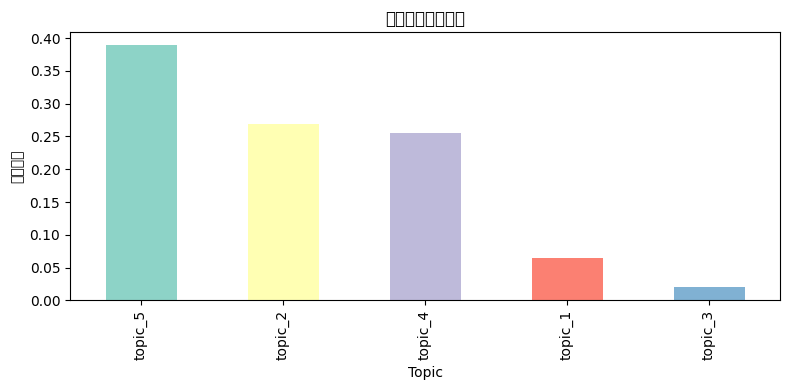

In [38]:
# fig, ax = plt.subplots(figsize=(15, 6))
# theta.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)

# plot.bar 太多筆評論，記憶體 Out of memory

# 改為顯示主題的整體分布比例
mean_topic_dist = theta.mean(axis=0).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 4))
mean_topic_dist.plot(kind='bar', color=plt.cm.Set3.colors)
plt.title("整體主題分布平均")
plt.ylabel("平均比例")
plt.xlabel("Topic")
plt.tight_layout()
plt.show()

In [39]:
for i in mean_topic_dist.index:
    print(f"{i}:")
    print(lda_model.print_topic(int(i.split('_')[-1]) - 1))  # topic_5 -> index 4
    print()

topic_5:
0.021*"staff" + 0.020*"great" + 0.017*"stay" + 0.012*"service" + 0.010*"location" + 0.010*"stayed" + 0.009*"friendly" + 0.008*"restaurant" + 0.008*"helpful" + 0.007*"would"

topic_2:
0.014*"nice" + 0.012*"good" + 0.009*"bathroom" + 0.008*"area" + 0.008*"restaurant" + 0.008*"great" + 0.008*"location" + 0.008*"bed" + 0.008*"street" + 0.007*"free"

topic_4:
0.010*"would" + 0.009*"one" + 0.009*"night" + 0.009*"desk" + 0.007*"service" + 0.007*"front" + 0.007*"stay" + 0.006*"day" + 0.006*"get" + 0.006*"time"

topic_1:
0.020*"und" + 0.013*"die" + 0.011*"ist" + 0.011*"der" + 0.010*"sehr" + 0.009*"est" + 0.008*"que" + 0.007*"trs" + 0.007*"ein" + 0.007*"zimmer"

topic_3:
0.019*"per" + 0.018*"con" + 0.018*"che" + 0.015*"molto" + 0.013*"non" + 0.012*"una" + 0.010*"sono" + 0.008*"della" + 0.008*"camera" + 0.007*"anche"



### 為什麼1-2星等的評論主題裡還是很多正向詞彙?
- 模型不知道什麼是好、什麼是壞，只會找頻繁共現的詞組，舉例: 
1. great + dirty + location 或是 staff + not + clean
2. The room was clean, and the staff was polite, but the bed was awful and the noise was unbearable.

- 可以考慮加入情緒分析(或字典)來過濾、解釋
